<a href="https://colab.research.google.com/github/StephMcCallum/MSE563-SM/blob/main/MD%20Week%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (829/829), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 3573 (delta 674), reused 646 (delta 646), pack-reused 2744 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 12.22 MiB/s, done.
Resolving deltas: 100% (2461/2461), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [1]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.8.0   | 682.5 MB  | :   0% 0/1 [00:00<?, ?it/s]
gcc_impl_linux-64-14 | 70.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


libllvm14-14.0.6     | 30.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



libflint-3.1.3.1     | 20.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




rdkit-2024.09.6      | 19.0 MB   | :   0% 0/1 [00:00<?, ?it/s]





parmed-4.3.0         | 18.5 MB   | :   0% 0/1 [00:00<?, ?it/s]






scipy-1.15.2         | 16.4 MB   | :   0% 0/1 [00:00<?, ?it/s]







libclang-cpp14-14.0. | 15.8 MB   | :   0% 0/1 [00:00<?, ?it/s]








pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]









sysroot_linux-64-2.1 | 14.5 MB 

In [2]:
import hoomd

In [20]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

In [4]:
kT = 1.0
epsilon = 1.0
sigma = 1.0
final_density = 1.0

In [5]:
import freud
starting_density = 0.5
#a is the spacing between particles
a = 1/(starting_density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

In [6]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

In [7]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

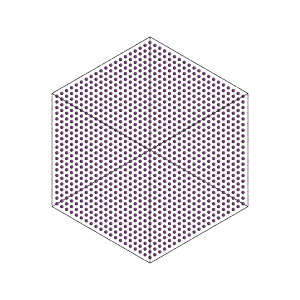

In [27]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(
    gsd_file="initial_state.gsd", frame=0, view_axis=(1, 1, 1)
)
sim_visualizer.view()

In [ ]:
del simulation

In [8]:
integrator = hoomd.md.Integrator(dt = 0.005)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

In [29]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

In [10]:
integrator.forces.append(lj)
simulation.operations.integrator = integrator

In [11]:
simulation.run(100)

In [12]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(simulation)
logger.add(thermodynamic_properties,quantities=['potential_energy'])
tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
tps_tracking.add(simulation, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
simulation.operations.writers.append(table)

In [13]:
print(thermodynamic_properties.potential_energy)

-24986.709102851004


In [ ]:

simulation.run(1e5)

Simulation.timestep  Simulation.tps 
       10000           102.31032    
       20000           102.19530    


In [35]:
dt = [0.0005, 0.001, 0.005, 0.01, 0.05]
avg_PE = []
pe = {}
for i in dt:
  del simulation
  pe[f"{i}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state.gsd')
  integrator = hoomd.md.Integrator(dt = i)
  nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
  integrator.methods.append(nve)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(1000):
      simulation.run(10)
      pe[f"{i}"].append(thermodynamic_properties.potential_energy)
  avg_PE.append(thermodynamic_properties.potential_energy)

Simulation.timestep  Simulation.tps 
       10000           210.56079    
Simulation.timestep  Simulation.tps 
       10000           192.01639    
Simulation.timestep  Simulation.tps 
       10000           111.45097    
Simulation.timestep  Simulation.tps 
       10000            76.81409    


**ERROR**: Particle with unique tag 650 is no longer in the simulation box.

Cartesian coordinates: 
x: 24.6625 y: 35.4976 z: -10.5732
Fractional coordinates: 
f.x: 1.47873 f.y: 1.90872 f.z: 0.0804027
Local box lo: (-12.5992, -12.5992, -12.5992)
          hi: (12.5992, 12.5992, 12.5992)


RuntimeError: Error computing cell list

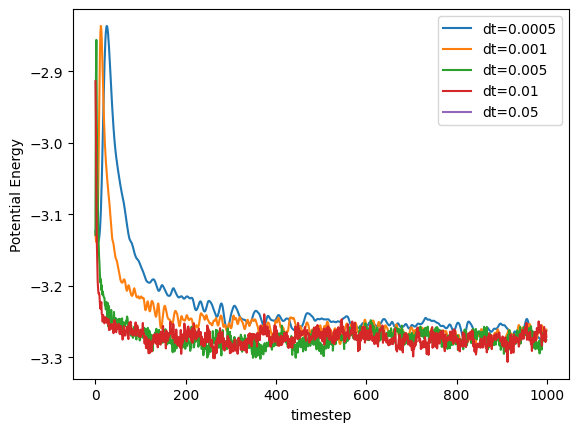

In [36]:
import matplotlib.pyplot as plt
for dt, p in pe.items():
  if dt == 0.05:
    continue
  plt.plot(numpy.array(p[0:])/N_particles, label=f'dt={dt}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

I ran into some issues running dt = 0.05. The error is related to a particle out of box, which is surprising with a lattice system and periodic boundary conditions.

Based on the other dt, as the step size decreases, the system relaxes to equillibrium more slowly.